# **Proces Ryzyka i ułamkowy ruch Browna**

***

Raport 2
<br>
**Kinga Curkowicz, 268774**
<br>
**Agata Kudlińska, 268739**
<br>
Symulacje komputerowe, grupa T00-22c

W naszym raporcie przedstawimy i zaimplementujemy proces Ryzyka oraz ułamkowy ruch Browna oraz związane z nimi zagadnienia. Wszystkie metody zostały zaimplementowane w Python'ie, a poniższe algorytmy pochodzą z wykładu, zajęć labolatoryjnych.

***

#### Spis treści
1. **Proces Ryzyka**
   <br>
   1.1 Estymacja $ \lambda $ i znalezienie rozkładu $X_i$<br>
   1.2 Symulacja procesu Ryzyka <br>
   1.3 Ruina Paryska
2. **Ułamkowy Ruch Browna**<br>
    2.1 Trajektorie Ruchu Browna, porównanie linii kwantylowych <br>
    2.2 Postać funkcji $E\tau^x$
3. Podsumowanie

***

#### **1. Proces Ryzyka**

$\textbf{Jednorodny proces Poissona}$ to proces stochastyczny $N(t)$ spełniający następujące warunki:
<br>
   - $N(0)=0$; <br>
   - $N(t)$ ma niezależne przyrosty; <br>
   - $N(t)$ ma stacjonarne przyrosty; <br>
   - $N(t) \sim Poiss(\lambda t)$.

$\textbf{Proces Ryzyka}$ to proces stochastyczny opisujący kapitał firmy ubezpieczeniowej. Wyraża się następującym wzorem:
\begin{equation*}
    R(t) = u + c(t) - \sum_{i=1}^{N(t)}X_i, t \in [0, T]
\end{equation*}
gdzie:
<br>
- $u>0$ - kapitał początkowy, <br>
- $c(t)$ - premia, czyli przychody uzyskane przez towarzystwo ze sprzedaży polis, <br>
- $X_i$ to niezależne zmienne losowe o tym samym rozkładzie reprezentujące wysokość $i - tej$ szkody <br>
- $N(t)$ -  liczba szkód do momentu $t$. <br>


Klasycznym procesem ryzyka nazywamy taki proces ryzyka R(t), gdzie N(t) jest jednorodnym procesem Poissona z intensywnością λ i
\begin{equation*}
    c(t) = (1 + θ)µλt
\end{equation*}
,gdzie $\mu = EX_i$ i θ jest parametrem odpowiedzialnym za wysokość premii.




***

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import curve_fit

#### Opis procedury wczytywania danych
Dane z pliku pobieramy przy pomocy json.load(file), poszeczególne dane z podanego słownika zapisujemy do zmiennych $ T, h, \theta $ , trajectory - są to odpowiednio: horyzont czasowy, krok czasowy, parametr $ \theta $ odpowiedzialny za wysokość premii.

In [40]:
with open('zestaw2_2.json', 'r') as file:
    json_data = json.load(file)

dict1 = dict(json_data)

T = int(dict1['T'])

h = float(dict1['h'])

theta = float(dict1['theta'])

trajectory = np.array(dict1['trajektoria'])

u = trajectory[0]

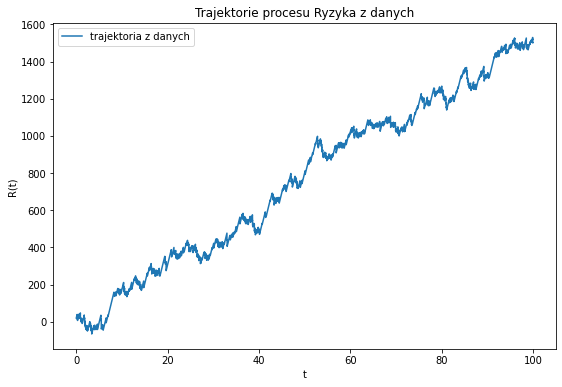

In [3]:
t1 = np.arange(0, T, h)
plt.figure(figsize=(9,6))
plt.plot(t1,trajectory[1:],label = "trajektoria z danych")
plt.xlabel('t')
plt.ylabel('R(t)')
plt.title('Trajektorie procesu Ryzyka z danych')
plt.legend()

1.1 Estymacja $ \lambda $ i znalezienie rozkładu $X_i$ <br>

Na początku zajmiemy się estymowaniem $ \lambda $, gdzie $\lambda $ to intensywność jednorodnego procesu Poissona. <br>

Sprawdzamy ile razy wartość kapitału jest mniejsza niż wartość w momencie wcześniej - jest to ilość zdarzeń. Jeśli wartość kapitału jest mniejsza niż była oznacza to, że nastąpiło wypłacenie szkody. Wyestymowana $ \lambda $ to ilość zdarzeń podzielona przez czas trawania, w naszym przypadku $ T = 100 $ (podane razem z danymi). 

In [4]:
def count_events(list_to_count):
    count = 0
    for i in range(1, len(list_to_count)):
        if list_to_count[i] < list_to_count[i-1]:
            count += 1
    return count

num_events = count_events(trajectory)
est_lambda = num_events/T
print("Wyestymowana lambda: ", est_lambda)


Wyestymowana lambda:  4.91


Przejdziemy teraz do estymowania rozkładu  $X_i$, gdzie $ X_i $ to wielkość i-tej szkody. Dany rozkład znajdziemy po przez odejmowanie wartości od kolejnej wartości kapitału, jeśli ta jest mniejsza.

In [5]:
def count_Xi(capital):
    xi = []
    for i in range(1, len(capital)):
        x = capital[i] - capital[i-1]
        if x < 0:
            xi.append(-x)
    return xi

xi = count_Xi(trajectory)

Text(0.5, 1.0, 'Histogram Xi')

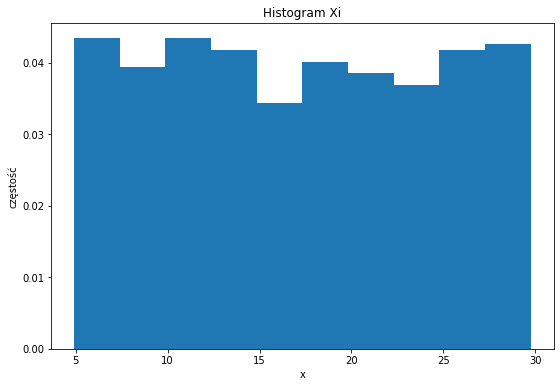

In [6]:
plt.figure(figsize=(9,6))
plt.hist(xi, bins = 10, density = True, label = "Histogram")
plt.xlabel('x')
plt.ylabel('częstość')
plt.title('Histogram Xi')

Zauważmy, że rozkład Xi przypomina rozkład jednostajny - zatem spróbujemy znaleźć paremetry tego rozkładu.

Wiemy, że gęstość prawdopodobieństwa rozkładu jednostajnego jest opisana poniższym wzorem:
$$ f(x) = \frac{1}{b-a} $$
dla $ a \leq x \leq b $

Dystrybuanta rozkładu jednostajnego:

$$F(x) = \begin{cases}
0 & \text{dla } x < a, \\
\frac{x - a}{b - a} & \text{dla } a \leq x < b, \\
1 & \text{dla } x \geq b,
\end{cases}$$

Aby wygenerować teorytyczny rozkład jednostajny dla parametrów z rozkładu Xi musimy znaleźć parametry loc i scale dla generatora z scipy.stats.uniform. Domyślnie jest rozkład na przedziale $ [0,1] $, aby go zmienić musimy podać parametry loc i scale, które są równe $ loc = min(Xi) $ , a $ loc + scale = max(Xi) $, min i max to odpowiednio początek i koniec przedziału na jakim chcemy wygenerować rozkład jednostajny.

In [7]:
loc = min(xi)

In [8]:
scale = max(xi) - min(xi)

In [9]:
loc + scale

29.760910391777543

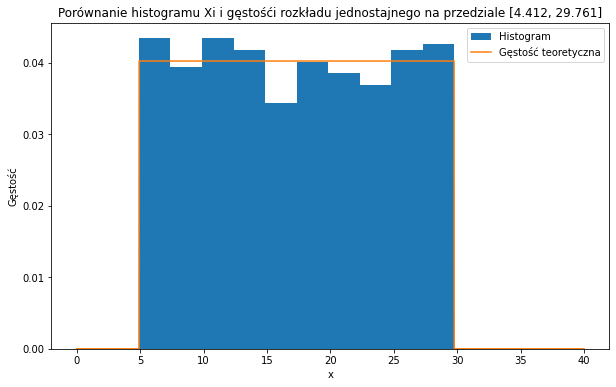

In [10]:
plt.figure(figsize=(10,6))
plt.hist(xi, bins = 10, density = True, label = "Histogram")
x = np.linspace(0,40,10000)
plt.plot(x, uniform.pdf(x, loc = loc, scale = scale), label='Gęstość teoretyczna')
plt.xlabel('x')
plt.ylabel('Gęstość')
plt.title("Porównanie histogramu Xi i gęstośći rozkładu jednostajnego na przedziale [4.412, 29.761]")
plt.legend()
plt.show()

Przejdziemy teraz do porównania dystrybuanty empirycznej z dystrybuantą teorytyczną.

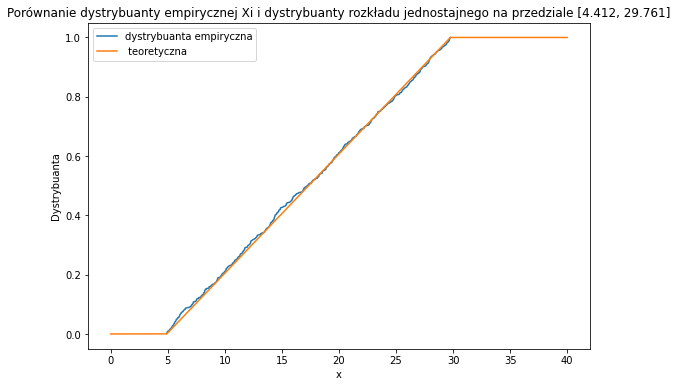

In [11]:
ecdf = ECDF(xi)
plt.figure(figsize=(9,6))
plt.plot(ecdf.x, ecdf.y, label = "dystrybuanta empiryczna")
x = np.linspace(0,40,10000)
plt.plot(x, uniform.cdf(x, loc = loc, scale = scale) , label=' teoretyczna')
plt.xlabel('x')
plt.ylabel('Dystrybuanta')
plt.title("Porównanie dystrybuanty empirycznej Xi i dystrybuanty rozkładu jednostajnego na przedziale [4.412, 29.761]")
plt.legend()
plt.show()

Możemu spostrzec, że histogram pokrywa się z gęstością teorytyczną, a dystrybuanta empiryczna z dystrybuantą teorytyczną - zatem Xi mają rozkład jednostajny na przedziale $ [min(Xi), max(Xi)] $, czyli około $ [4.412, 29.761] $.

#### 1.2 Symulacja procesu Ryzyka <br>

$\textbf{Jednorodny proces Poissona}$ to proces stochastyczny $N(t)$ spełniający następujące warunki:
<br>
   - $N(0)=0$; <br>
   - $N(t)$ ma niezależne przyrosty; <br>
   - $N(t)$ ma stacjonarne przyrosty; <br>
   - $N(t) \sim Poiss(\lambda t)$.

##### Algorytm:

1. Wstaw $I = 0$, $t = 0$.
2. Generuj $U \sim U(0, 1)$.
3. Wstaw $t = t - \frac{1}{\lambda} \log U$. Jeżeli $t > T$, STOP.
4. Wstaw $I = I + 1$, $S_I = t$.
5. Wróć do punktu 2.

In [12]:
def t_poisson(lambda1, T):
    I = 0
    t = 0
    t_list = []
    t_list.append(t)
    while t < T:
        U = np.random.uniform()
        t = t - (1/lambda1)*np.log(U)
        t_list.append(t)
        I += 1
    return t_list

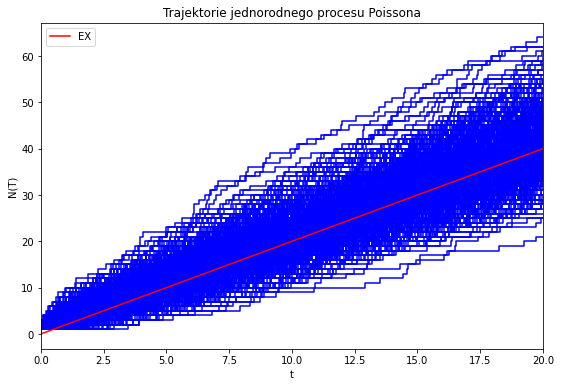

In [13]:
steps = []

plt.figure(figsize=(9,6))
for i in range(1000):
    s = t_poisson(2, 20)
    steps.append(len(s))
    plt.step(s, list(range(len(s))) ,color = 'blue')

x = np.linspace(0, 20, len(s))

plt.plot(x,2*x, color = 'red', label = 'EX')
plt.xlabel('t')
plt.ylabel('N(T)')
plt.xlim(0,20)
plt.title("Trajektorie jednorodnego procesu Poissona")
plt.legend()

Na powyższym wykresie wygenerowaliśmy trajektorie jednorodnego procesu Poissona.

Dopasowaliśmy model, zatem przejdziemy do następnego kroku, czyli symulacji. Wysymulowaliśmy 100 trajektorii procesu Ryzyka za pomocą poniższego algorytmu.

##### Algorytm:
1. Generuj $N(t)$ na $[0,T]$
2. Generuj $X_1, \ldots, X_{N(t)}$
3. Wstaw $R(t)=u+c(t)-\sum_{i=1}^{N(t)} X_i$

In [37]:
from numba import jit

def proces_ryzyka(u,T, h, theta, lambda1):
    t = np.arange(0,T,h)
    p = t_poisson(lambda1, T)[1:]
    R = np.ndarray(len(p))
    x = uniform.rvs(loc = loc, scale = scale, size = len(p))
    c = lambda t: (1+theta)*(lambda1*t*np.mean(x))
    for index, i in enumerate(p):
        R[int(index)] = u + c(p[index]) - np.sum(x[:index])
    return R, p

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


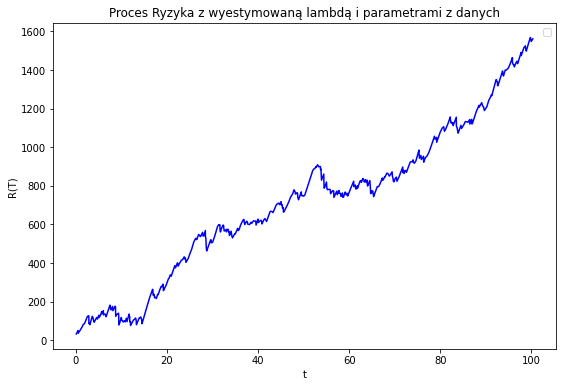

In [41]:
R, t = proces_ryzyka(u,T,h, theta, est_lambda)

plt.figure(figsize=(9,6))
plt.plot(t, R, color = 'blue')
plt.xlabel('t')
plt.ylabel('R(T)')
plt.title("Proces Ryzyka z wyestymowaną lambdą i parametrami z danych")
plt.legend()

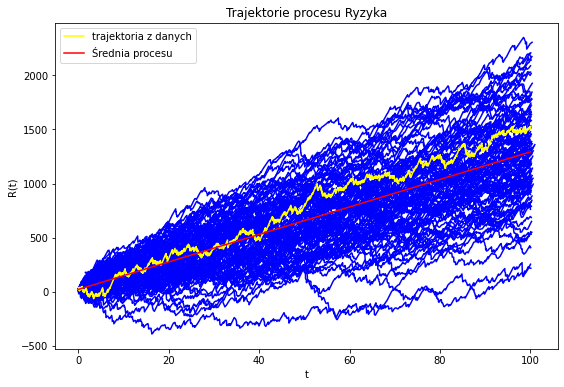

In [16]:
plt.figure(figsize=(9,6))

for _ in range(100):
    R, t = proces_ryzyka(u, T, h, theta, est_lambda)
    plt.plot(t, R, color = 'blue')

t1 = np.arange(0, T, h)
plt.plot(t1,trajectory[1:],label = "trajektoria z danych", color = 'yellow')
plt.plot(t1, u + theta*np.mean(xi)*est_lambda*t1, color = 'red', label = "Średnia procesu")

plt.xlabel('t')
plt.ylabel('R(t)')
plt.title('Trajektorie procesu Ryzyka')
plt.legend()

Kolorem niebieskim są trajektorie procesu Ryzyka z wyestymowaną $ \lambda $ i resztą parametrów z otrzymanych danych. Średnia procesu jest równa:
\begin{equation*}
    \rm{E}[R(t)] = u + \mu \lambda \theta t
\end{equation*}
Innym kolorem została zaznaczona trajektoria z zadanego pliku danych.

***

$\textbf{Prawdopodobieństwo ruiny}$ 

Kolejnym etapem zadania jest oszacowanie prawdopodobieństwa ruiny otrzymanego procesu Ryzyka. Prawdopodobieństwo to dla skończonego horyzontu czasowego $T$ wyraża się następującym wzorem:

\begin{equation*}
    \Psi (u, T) = P(\tau(u) <T),
\end{equation*}
jest to prawdopodobieństwo tego, że ruina, inaczej bankructwo, nastąpiła przed czasem $T$. Występujące we wzorze $\tau (u)$ jest $\textbf{momentem ruiny}$ , czyli najmniejszym momentem czasowym takim, że proces Ryzyka spada poniżej $0$, $\tau (u) = \inf \{t \geq 0: R(t) <0\}$. Jest to zmienna losowa. Aby je oszacować należy wykorzystać metodę Monte Carlo, czyli wielokrotnie, sprawdzić ile trajektorii wygenerowanego procesu Ryzyka spadło poniżej zera i podzielić tę ilość przez liczbę powtórzeń. Algorytm wygląda następująco: 

##### Algorytm:
1. Generuj N trajektorii $R^{(1)}(t),\ldots, R^{(N)}(t)$ procesu Ryzyka na $[0,T]$
2. Wyznacz $n=\{i \in \{1,\ldots, N\}: \min_{t\in[0,T]} R^{(i)}(t) < 0 \}$
3. Wstaw $\Psi(u,T)=\frac{n}{N}$

Dla T = 100 i T = 200

In [17]:
def prob_ruin(T, N = 1000):
    n = 0
    for i in range(N):
        R, t = proces_ryzyka(u,T,h, theta, est_lambda)
        if min(R) < 0:
            n += 1
    return n/N

p100 = prob_ruin(T)
p200 = prob_ruin(200)
print("Prawdopodobieństwo ruiny dla T = 100: ", p100)
print("Prawdopodobieństwo ruiny dla T = 200: ", p200)

Prawdopodobieństwo ruiny dla T = 100:  0.54
Prawdopodobieństwo ruiny dla T = 200:  0.521


***

$\textbf{Prawdopodobieństwo ruiny w nieskończonym czasie}$

W kolejnym etapie raportu oszacujemy prawdopodobieństwo ruiny w nieskończonym czasie korzystając ze wzoru Pollaczka–Chinczyna, który wygląda następująco:
\begin{equation*}
    \Psi(u) = \frac{\theta}{1+\theta}\sum_{n=0}^{\infty} \left(\frac{1}{1+\theta}\right)^n \cdot B_n(u),
\end{equation*}
gdzie $B_n(u) = P(Y_1+\ldots+Y_n>u)$ oraz $Y_i$ to niezależne zmienne losowe z rozkładu o gęstości $f(x) = \frac{1-F_{X_i}(x)}{\mu}$ dla $EX_i = \mu$. W symulacji tego prawdopodobieństwa korzysta się z faktu, że $\Psi(u)=P(Y_1+\ldots+Y_K>u)$, gdzie $K\sim Geo\left(\frac{\theta}{1+\theta}\right)$, więc $P(K=i) = \frac{\theta}{1+\theta}\left(1-\frac{\theta}{1+\theta}\right)^i$ dla $i=0,1,\ldots$. 

Poniżej przedstawimy dokładny algorytm symulacji prawdopodobieństwa ruiny w nieskończonym czasie za pomocą metody Monte Carlo.
##### Algorytm:
1. utwórz listę $Z$ o długości $N$ składającą się z zer 
2. utwórz pętle od $1$ do $N$
3. generuj $K\sim Geo\left(\frac{\theta}{1+\theta}\right)$
4. generuj $Y_1,\ldots,Y_K$ iid o gęstości $f(x) = \frac{1-F_{X_i}(x)}{\mu}$ 
5. jeśli $Y_1+\ldots+Y_K>u$ wstaw $Z(i)=1$
6. zakończ pętle
7. wstaw $\Psi(u)=\frac{Z(1)+\ldots+Z(N)}{N}$

W przypadku, gdy $X_i  \sim U(min(xi), max(xi)) $ i $ x \in [a, b] $ , to $Y_i$ ma rozkład, gdzie $ a = min(xi), b = max(xi) $
\begin{equation*}
    f(x)=\frac{1 - \left(\frac{x - \min(x_i)}{\max(x_i) - \min(x_i)}\right)}{{\mu}} = \frac{{2(b - x)}}{{b^2 - a^2}}.
\end{equation*}

\begin{equation*}
    f(x) = \begin{cases}
    \frac{1 - \left(\frac{x - \min(x_i)}{\max(x_i) - \min(x_i)}\right)}{\mu}, 
    & \text{dla } x \in [\min(x_i), \max(x_i)], \\
    \frac{1}{\mu}, & \text{dla } x \in [0, \min(x_i)],
    \end{cases}
\end{equation*}

Yi generujemy za pomocą metody akceptacji-odrzucenia

Metoda akceptacji-odrzucenia <br>
Chcemy wygenerować zmienną losową ciągłą $X$ o gęstości $f(x)$
<br>
Założenia:
1. Potrafimy generować inną zmienną losową $ Y $ o gęstości $ g(x) $ oraz Y i zmienna, którą chcemy wygenerować muszą przyjmować wartości z tego samego zbioru
2. Potrafimy wyznaczyć stałą $ c $ taką, że $ sup_{x \in \mathbb{R}} \frac{f(x)}{g(x)} \leq c \leq \infty $
<br>


Algorytm:
1. Generuj $Y$
2. Generuj $ U \sim \mathcal{U}(0,1) $, $  U \perp Y $
3. Jeśli $ U \leq \frac{f(Y)}{cg(Y)} $ zwróć $ X =Y $. Jeśli nie - wróc do 1.

Rozkład pomocniczy $ Y \sim U(0, max(xi)) $
<br>
Gęstość pomocniczego
$$ g(x) = \frac{1}{max(xi)} $$
na przedziale $ [0, max(xi)]$, poza tym 0

Wyznaczenie c

In [18]:
fx = 1/np.mean(xi)
gx = 1/(max(xi))
c = fx/gx

In [19]:
c

1.7225495817202718

In [20]:
def generate_yi(num_samples):
    samples = []
    while len(samples) < num_samples:
        a = min(xi)
        b = max(xi)
        Y = np.random.uniform(0, b)
        U = np.random.uniform()
        fx1 = 1/np.mean(xi) # na przedziale [0,a]
        fx = lambda x: 2*(b-x)/(b**2 - a**2) # na przedziale [a,b]
        gx = 1/b
        if U <= fx(Y)/(c*gx) and Y >= a:
            samples.append(Y)
        elif U <= fx1/(c*gx) and Y < a:
            samples.append(Y)
    
    return samples

In [42]:
def poll_chin(u,theta,N = 1000):
    I = 0
    for i in range(N):
        k = np.random.geometric(theta/(1 + theta)) - 1
        Y = generate_yi(k)
        if np.sum(Y) > u:
            I += 1
    return I/N

p = poll_chin(u, theta, N = 1000)
print(p)

0.697


In [44]:
print("Prawdopodobieństwo ruiny w nieskończonym czasie wynosi około:", p)

Prawdopodobieństwo ruiny w nieskończonym czasie wynosi około: 0.697


***

#### 1.3 Ruina Paryska
Moment wystąpienia ruiny typu paryskiego definiowany jest jako moment, w którym kapitały firmy ubezpieczeniowej był ujemny przez zdefiniowany okres czasu $q$, gdzie $q$ to ilość jednostek czasu.

In [22]:
def ruin_probability(q, u, T, h, theta, lambda1):
    count = 0  
    capital, t = proces_ryzyka(u, T, h, theta, lambda1)
    for i in range(len(t)):
        if capital[i] < 0:
            count += 1
            if count >= q:
                return 1  # Firma zbankrutowała
        else:
            count = 0
    return 0  # Firma przetrwała

def calculate_ruin_probability(q, u, T, h, theta, lambda1):
    ruin_count = 0
    iterations = 1000
    for _ in range(iterations):
        if ruin_probability(q, u, T,h, theta, lambda1) == 1:
            ruin_count += 1
    return ruin_count / iterations


q = 2

probability = calculate_ruin_probability(q, u, T, h, theta, est_lambda)
print(f"Prawdopodobieństwo ruiny dla q = {q}: {probability}")


Prawdopodobieństwo ruiny dla q = 2: 0.464


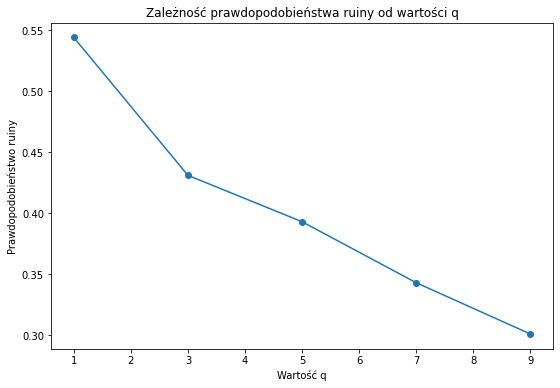

In [23]:
def plot_ruin_probability(q_values):
    probabilities = []
    for q in q_values:
        probability = calculate_ruin_probability(q, u, T, h, theta, est_lambda)
        probabilities.append(probability)
    
    plt.figure(figsize=(9,6))
    plt.plot(q_values, probabilities, 'o-')
    plt.xlabel('Wartość q')
    plt.ylabel('Prawdopodobieństwo ruiny')
    plt.title('Zależność prawdopodobieństwa ruiny od wartości q')
    plt.show()

q_values = [1,3,5,7,9]

plot_ruin_probability(q_values)

Im większe q tym mniejsze prawdopodobieństwo ruiny.

Średni czas ruiny w zależności od wartości q

Średni czas ruiny dla q=1: 1.714447309020711
Średni czas ruiny dla q=5: 2.047809968754696
Średni czas ruiny dla q=10: 1.8887332961453809
Średni czas ruiny dla q=20: 2.030041245657642
Średni czas ruiny dla q=30: 1.3898221736636613


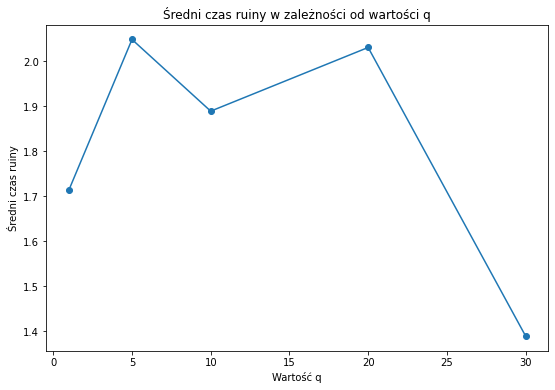

In [24]:
def calculate_average_ruin_time(q_values):
    average_times = []
    iterations = 1000
    for q in q_values:
        time = 0
        for _ in range(iterations):
            capital, t = proces_ryzyka(u, T, h, theta, est_lambda)
            count = 0
            for i in range(len(t)):
                if capital[i] < 0:
                    count += 1
                else:
                    count = 0
                if count >= q:
                    time += t[i]
                    break
        average_time = time / iterations
        average_times.append(average_time)

    return average_times

q_values = [1, 5, 10, 20, 30]

average_times = calculate_average_ruin_time(q_values)
for q, avg_time in zip(q_values, average_times):
    print(f"Średni czas ruiny dla q={q}: {avg_time}")

plt.figure(figsize=(9,6))
plt.plot(q_values, average_times, 'o-')
plt.xlabel('Wartość q')
plt.ylabel('Średni czas ruiny')
plt.title('Średni czas ruiny w zależności od wartości q')
plt.show()


Średni czas ryzyka jest różny dla różnych q. Na wykresie przedstawiony jest dla q = [1, 5, 10, 20, 30].

Prawdopodobieństwo ruiny w zależności od wartości u - kapitał początkowy

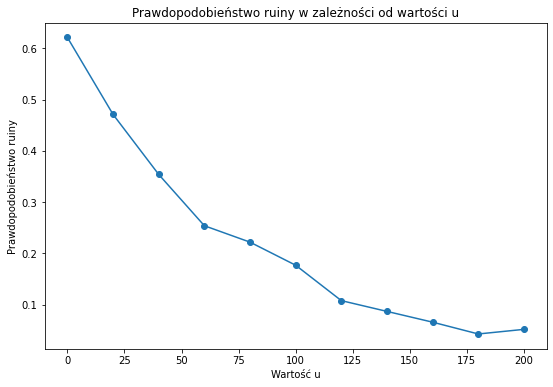

In [25]:
u_values = np.arange(0, 201, 20)
q = 2
probabilities = []

for u in u_values:
    probability = calculate_ruin_probability(q, u, T, h, theta, est_lambda)
    probabilities.append(probability)

plt.figure(figsize=(9,6))
plt.plot(u_values, probabilities, 'o-')
plt.xlabel('Wartość u')
plt.ylabel('Prawdopodobieństwo ruiny')
plt.title('Prawdopodobieństwo ruiny w zależności od wartości u')
plt.show()


Widać, że im większy kapitał początkowy tym mniejsze prawdopodobieństwo ruiny.

***

#### **2. Ułamkowy Ruch Browna**

 Ruch Browna, czyli inaczej proces Wienera to jeden z najbardziej znanych procesów o rozkładach skończenie wymiarowych, gaussowskich i ponadto jest szczególnym przypadkiem procesu Levy'ego. Ma swoje zastosowanie w matematyce teoretycznej i stosowanej, w fizyce oraz w finansach. Jest to proces stochastyczny $\left(B_t\right)_{t\geq 0}$ spełniający następujące warunki:
<br>

1. $B(0) = 0$;
2. $B(t) \sim \mathcal{N}(0,1)$;
3. Ma niezależne i stacjonarne przyrosty;
4. Ma ciągłe trajektorie.

W naszym przypadku wykorzystamy oznaczenie procesu Wienera startującego z $x \in \mathbb{R}$ jako: $B_t^x = B_t^0 +x$ ,gdzie $B_t^0$ to klasyczny ruch Browna startujący z $0$. 

$\textbf{Metoda rozkładu Choleskiego dla ułamkowego ruchu Browna}$

Ułamkowym ruchem Browna $BH(t)$, $t \in [0, T]$, $H \in (0, 1]$, nazywamy proces gaussowski o funkcji średniej $m(t) = EBH(t) = 0$ oraz funkcji autokowariancji $c(s, t) = \text{Cov}(BH(s), BH(t)) = \sigma^2 \left(t^{2H} + s^{2H} - |t - s|^{2H}\right)$.

Załóżmy, że chcemy wygenerować trajektorię ułamkowego ruchu Browna $BH(t)$, $t \in [0, T]$, z $\sigma = 1$. Dzielimy zatem przedział $[0, T]$ na $N + 1$ równych podprzedziałów $[t_{i-1}, t_i]$ o długości $t_i - t_{i-1} = \frac{T}{N}$, gdzie $i = 1, \ldots, N$, i znajdujemy wartość procesu $BH(t)$ w punktach $t_i$. Zauważmy, że korzystając z samopodobieństwa ułamkowego ruchu Browna, mamy $BH(t_i) = \left(\frac{T}{N}\right)^H BH(i)$. Wystarczy, wieć znaleźć wartości $BH(1)$, $BH(2)$, $\ldots$, $BH(N)$. Możemy rozważać tylko zmienne losowe $X_1 = BH(2) - BH(1)$, $X_2 = BH(3) - BH(2)$, $\ldots$, $X_N = BH(N) - BH(N-1)$, ze względu na stacjonarność przyrostów ułamkowego ruchu Browna. Wówczas $BH(0) = 0$ i $BH(k) = \sum_{i=0}^{k} X_i$, dla $k \geq 1$. Zmienne $X_1, X_2, \ldots$ nazywamy ułamkowym szumem gaussowskim.

W celu sprawdzenia poprawności zaimplementowanego generatora ułamkowego ruchu Browna $BH(t)$ możemy porównać empirycznie wyznaczone linie kwantylowe z teoretycznymi. Linie kwantylowe dla procesu $BH(t)$ mają postać $qp(t) = t^H \cdot qp$, gdzie $qp$ to kwantyl rzędu $p$ rozkładu $N(0, \sigma^2)$.

***

**2.1 Trajektorie Ruchu Browna, porównanie linii kwantylowych** 

Wygenerujemy teraz po 30 trajektorii ułamkowego ruchu Browna z H = 0.2 i H = 0.8 (dla 100 czas wywołania byłby bardzo długi),
i porównamy linie kwantylowe wyznaczone empirycznie z teoretycznymi liniami kwantylowymi dla p = 0.05,0.3,0.7,0.95.

In [26]:
def fractional_brownian_motion(H, N, T):
    gamma_func = lambda k, H: 0.5 * ((k + 1) ** (2 * H) + np.abs(k - 1) ** (2 * H) - 2 * k ** (2 * H))
    L = np.zeros((N, N))
    L[0, 0] = 1
    Z = np.random.normal(0, 1, size=N)
    L[1, 0] = gamma_func(1, H)
    L[1, 1] = np.sqrt(1 - gamma_func(1,H) ** 2)

    for n in range(2, N):
        L[n, 0] = gamma_func(n, H)
        for j in range(2, n):
            L[n, j] = (1 / L[j, j]) * (gamma_func(n - j, H) - np.sum(np.dot(L[n, 0:j], L[j, 0:j])))

        L[n, n] = np.sqrt(1 - np.sum((L[n, 0:n] ** 2)))

    X = np.zeros(N)
    for n in range(N):
        X[n] = np.dot(L[n, 0:n+1], Z[0:n+1])

    bh = np.cumsum(X)
    return ((T / N) ** H) * (bh)

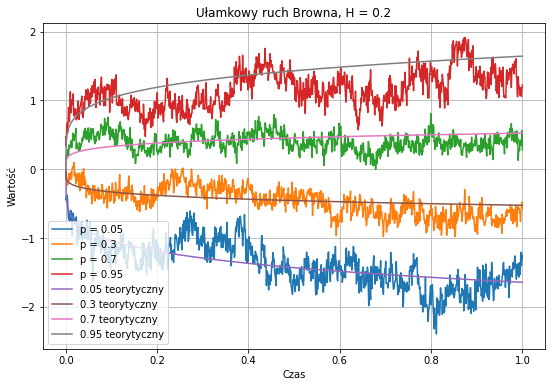

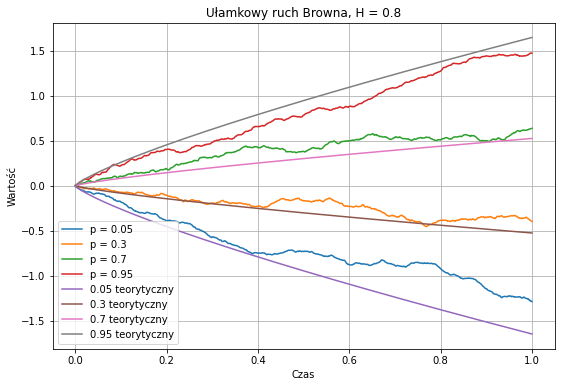

In [27]:
H_values = [0.2, 0.8]
N = 1000
T = 1
p_values = [0.05, 0.3, 0.7, 0.95]

for H in H_values:
    trajectories = []
    for _ in range(30):
        W = fractional_brownian_motion(H, N, T)
        trajectories.append(W)

    quantiles = np.percentile(trajectories, [p * 100 for p in p_values], axis=0)
    plt.figure(figsize=(9,6))
    t = np.linspace(0, T, N+1)
    t_plot = np.linspace(0, T, N)
    for q, p in zip(quantiles, p_values):
        plt.plot(t_plot, q, label=f'p = {p}')
    plt.plot(t_plot, (t_plot**H)*norm.ppf(0.05), label = '0.05 teorytyczny')
    plt.plot(t_plot, (t_plot**H)*norm.ppf(0.3), label = '0.3 teorytyczny')
    plt.plot(t_plot, (t_plot**H)*norm.ppf(0.7), label = '0.7 teorytyczny')
    plt.plot(t_plot, (t_plot**H)*norm.ppf(0.95), label = '0.95 teorytyczny')
    plt.xlabel('Czas')
    plt.ylabel('Wartość')
    plt.title(f'Ułamkowy ruch Browna, H = {H}')
    plt.grid(True)
    plt.legend()
    plt.show()

Udało nam się poprawnie wygenerować trajektorie Ruchu Browna, gdyż pokrywają się z teoretycznymi liniami kwantylowymi.

***

Przejdziemy teraz do generowania trajektorii oraz do estymowania średniego czasu wyjścia z podanego przedziału (dla a lub - a). Symulacje zostało wykonane za pomocą metody Monte Carlo dla różnych parametrów $x$, od których rozpoczynały się trajektorie procesu.

In [28]:
def fractional_brownian_motion_bh(H, N):
    gamma_func = lambda k, H: 0.5 * ((k + 1) ** (2 * H) + np.abs(k - 1) ** (2 * H) - 2 * k ** (2 * H))
    L = np.zeros((N, N))
    L[0, 0] = 1
    Z = np.random.normal(0, 1, size=N)
    L[1, 0] = gamma_func(1, H)
    L[1, 1] = np.sqrt(1 - gamma_func(1,H) ** 2)

    for n in range(2, N):
        L[n, 0] = gamma_func(n, H)
        for j in range(2, n):
            L[n, j] = (1 / L[j, j]) * (gamma_func(n - j, H) - np.sum(np.dot(L[n, 0:j], L[j, 0:j])))

        L[n, n] = np.sqrt(1 - np.sum((L[n, 0:n] ** 2)))

    X = np.zeros(N)
    for n in range(N):
        X[n] = np.dot(L[n, 0:n+1], Z[0:n+1])

    bh = np.cumsum(X)
    return bh

**2.2 Postać funkcji $E\tau^x$**
<br>

W kolejnej części znajdziemy symulacyjnie postać funkcji Eτx i obliczymy jej wartości.

Przypadek dla a = 10:

In [29]:
def e_tau(x, N, a):
    E_tau_x = np.zeros(100)
    for i in range(100):
        w = fractional_brownian_motion_bh(0.5, N) + x
        tau_x = np.sum(np.abs(w) < a)
        E_tau_x[i] = tau_x
    return np.mean(E_tau_x)

In [30]:
a = 10

x_values = np.linspace(-30, 30, 61)
e_tau_list10 = []

for x in x_values:
    E_tau_x = e_tau(x, 100,a)
    e_tau_list10.append(E_tau_x)

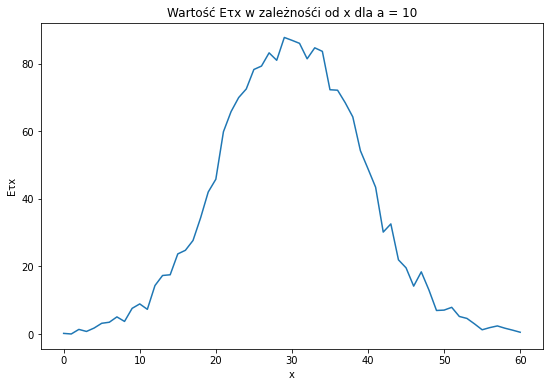

In [31]:
plt.figure(figsize=(9,6))
plt.plot(e_tau_list10)
plt.xlabel('x')
plt.ylabel('Eτx')
plt.title('Wartość Eτx w zależnośći od x dla a = 10')
plt.show()

W następnym kroku dopasujemy krzywą Gaussa do naszych danych, przy użyciu funkcji curve_fit z biblioteki scipy.optimize.
Na początku definiujemy wektor x_data, który jest równomiernie rozmieszczonymi wartościami od -30 do 30 oraz wektor y_data zawierający odpowiadające wartości y, które chcemy dopasować. W kolejnym kroku definiujemy funkcję Gaussa i określamy początkowe wartości parametrów, które będą używane przez algorytm dopasowujący. W tym przypadku przyjmujemy wartość 1 dla każdego parametru, ale można dostosować te wartości do swojego przypadku. Wywołujemy funkcję curve_fit, która wykonuje dopasowanie krzywej Gaussa do danych. Przekazujemy do niej funkcję gaussian_func, dane x_data i y_data, oraz początkowe przybliżenie parametrów initial_guess. Funkcja curve_fit zwraca optymalne wartości parametrów. Następnie tworzymy wektor x_curve do wygenerowania gładkiej krzywej Gaussa i obliczamy odpowiadające wartości y (y_curve) dla tego wektora, używając optymalnych parametrów optimized_params. Na końcu tworzymy wykres ilustujący dopasowanie danych oraz krzywej Gaussa.

[88.32744351 -0.10068404  9.05441417]


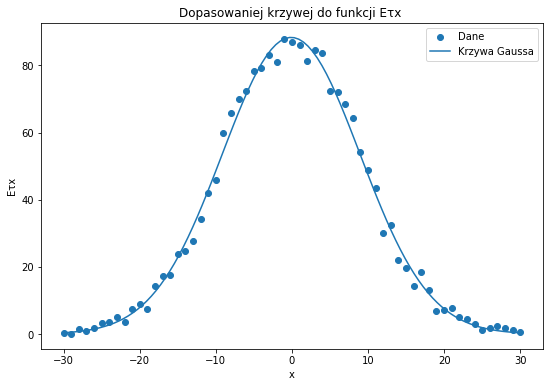

In [32]:
x_data = np.linspace(-30, 30, 61)
y_data = np.array(e_tau_list10)

def gaussian_func(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

initial_guess = [1, 1, 1]
optimized_params, _ = curve_fit(gaussian_func, x_data, y_data, p0=initial_guess)
print(optimized_params)

x_curve = np.linspace(min(x_data), max(x_data), 100)
y_curve = gaussian_func(x_curve, *optimized_params)

plt.figure(figsize=(9,6))
plt.scatter(x_data, y_data, label='Dane')
plt.plot(x_curve, y_curve, label='Krzywa Gaussa')
plt.xlabel('x')
plt.ylabel('Eτx')
plt.title("Dopasowaniej krzywej do funkcji Eτx ")
plt.legend()
plt.show()


Udało nam się dopasować krzywą Gaussa z następującymi parametrami: $A = 88.32744351 $, gdzie $A$ oznacza amplitudę, czyli wysokość krzywej Gaussa, $\mu = -0.10068404$, gdzie $\mu$ oznacza środek, czylivwartość oczekiwaną krzywej Gaussa oraz $\sigma = 9.05441417$, gdzie $\sigma$ oznacza odchylenie standardowe krzywej Gaussa.

Dla a = 5 obliczymy wartości funkcji Eτx dla różnych wartości x.

In [33]:
a = 5

x_values = np.linspace(-30, 30, 61)
e_tau_list5 = []

for x in x_values:
    E_tau_x = e_tau(x, 100,a)
    e_tau_list5.append(E_tau_x)

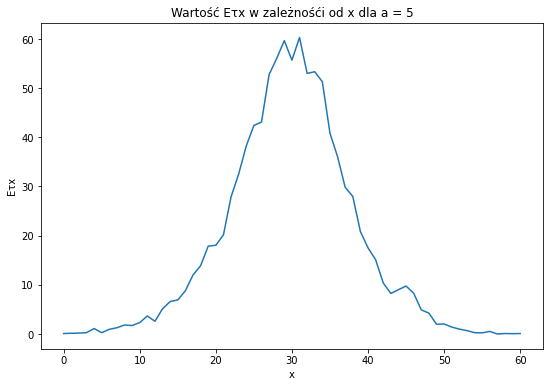

In [34]:
plt.figure(figsize=(9,6))
plt.plot(e_tau_list5)
plt.xlabel('x')
plt.ylabel('Eτx')
plt.title('Wartość Eτx w zależnośći od x dla a = 5')
plt.show()

[56.70570555 -0.06036547  6.82735536]


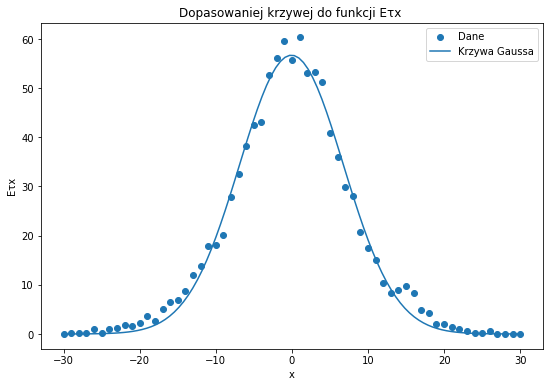

In [45]:
x_data = np.linspace(-30, 30, 61)
y_data = np.array(e_tau_list5)

initial_guess = [1, 1, 1] 
optimized_params, _ = curve_fit(gaussian_func, x_data, y_data, p0=initial_guess)
print(optimized_params)

x_curve = np.linspace(min(x_data), max(x_data), 100)
y_curve = gaussian_func(x_curve, *optimized_params)

plt.figure(figsize=(9,6))
plt.scatter(x_data, y_data, label='Dane')
plt.plot(x_curve, y_curve, label='Krzywa Gaussa')
plt.xlabel('x')
plt.ylabel('Eτx')
plt.title("Dopasowaniej krzywej do funkcji Eτx ")
plt.legend()
plt.show()


Udało nam się dopasować krzywą Gaussa z następującymi parametrami: $A = 56.70570555$, gdzie $A$ oznacza amplitudę, czyli wysokość krzywej Gaussa, $\mu = -0.06036547$, gdzie $\mu$ oznacza środek, czyli wartość oczekiwaną krzywej Gaussa oraz $\sigma = 6.82735536$, gdzie $\sigma$ oznacza odchylenie standardowe krzywej Gaussa.

***

#### **3. Podsumowanie**

Udało nam się dopasować model klasycznego procesu Ryzyka do danych otrzymanych od prowadzącego, oszacować prawdopodobieństwo ruiny otrzymanego procesu Ryzyka dla skończonego horyzontu czasowego: T = 100 i T = 200 przy pomocy metody Monte Carlo. Następnie, wykorzystałyśmy algorytm na podstawie wzoru Pollaczka–Chinczyna, aby oszacować prawdopodobieństwo ruiny naszego procesu Ryzyka w nieskończonym czasie. W kolejnej części wyznaczyliśmy prawdopodobieństwo ruiny w zależności od wartości $q$ - gdzie $q$ to ilość jednostek czasu oraz w zależności od wartości $u$, gdzie $u$  to kapitał początkowy. W drugiej części raportu wygenerowaliśmy po 30 trajektorii ułamkowego ruchu Browna dla $H=0.2$ oraz $H=0.8$, porównaliśmy również kwantylowe wyznaczone empirycznie z teoretycznymi liniami kwantylowymi dla różnych wartości p. Następnie symulacyjnie wyznaczyliśmy postać funkcji Eτ x w zależności od x oraz dopasowaliśmy odpowiednią funkcję do otrzymanych danych.